In [1]:
from scipy import integrate
import matplotlib.pyplot as plt
import numpy as np
from scipy import optimize
import emcee 
%matplotlib inline


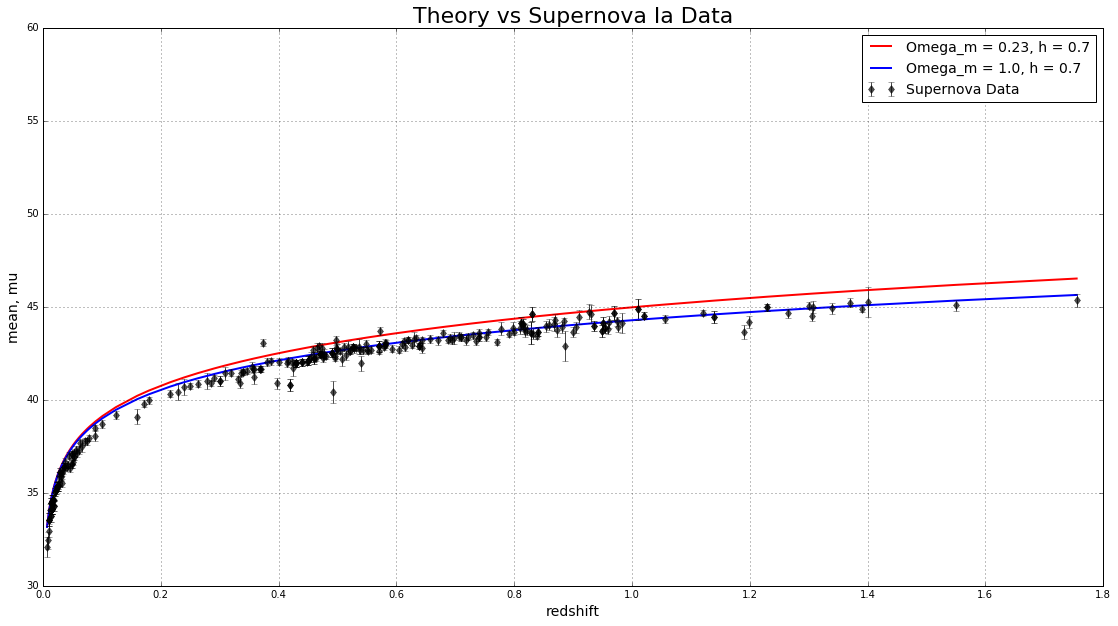

In [2]:
z_data = np.genfromtxt('/Users/noahknoblauch/PHY154/SN.dat', skip_header=1, usecols=(1))
mu_data = np.genfromtxt('/Users/noahknoblauch/PHY154/SN.dat', skip_header=1, usecols=(2))
err_data = np.genfromtxt('/Users/noahknoblauch/PHY154/SN.dat', skip_header=1, usecols=(3))

z = np.array(z_data)
mu = np.array(mu_data)
err = np.array(err_data)

z.sort()
for i in range(len(z)):
    for j in range(len(z)):
        if z_data[j] == z[i]:
            mu[i] = mu_data[j]
            err[i] = err_data[j]

Omega_m = 0.23
Omega_m1 = 1.0
h_0 = 0.7
steps = len(z) 

params0 = [h_0, Omega_m]
params1 = [h_0, Omega_m1]

def f(z, params):
    h, OmegaM = params
    OmegaL = 1.0-OmegaM 
    f = (3000.0/h)/(np.sqrt(OmegaM*np.power((1.0+z),3.0)+OmegaL)) 
    return f


def Dc(z, params):
    h, OmegaM = params
    Dc = [] 
    f_int = lambda z: f(z, params) 
    for i in range(steps): 
        intEz = integrate.quad(f_int,0.0,z[i]) 
        Dc.append(intEz[0]) 
    return Dc

def DL(z, params):
    h, OmegaM = params
    DL = (1.0+z)*Dc(z, params) # no h!
    return DL


def MU(z, params):
    h, OmegaM = params
    MU = [] 
    MU = 25.0 - 5.0*np.log10(h) + 5.0*np.log10(DL(z, params))
    return MU


plt.figure(figsize=(19,10))
plt.plot(z, MU(z, params0), color='r', linewidth=2, label='Omega_m = 0.23, h = 0.7')
plt.plot(z, MU(z, params1),color= 'blue', linewidth=2, label='Omega_m = 1.0, h = 0.7')
plt.errorbar(z, mu, yerr=err, fmt='cd', color='black',  alpha=0.7, label='Supernova Data')
plt.legend(fontsize=14, loc=1)
plt.ylim(30,60)
plt.grid()
plt.xlabel('redshift',fontsize=14)
plt.ylabel('mean, mu',fontsize=14)
plt.title('Theory vs Supernova Ia Data',fontsize=22)
plt.show()

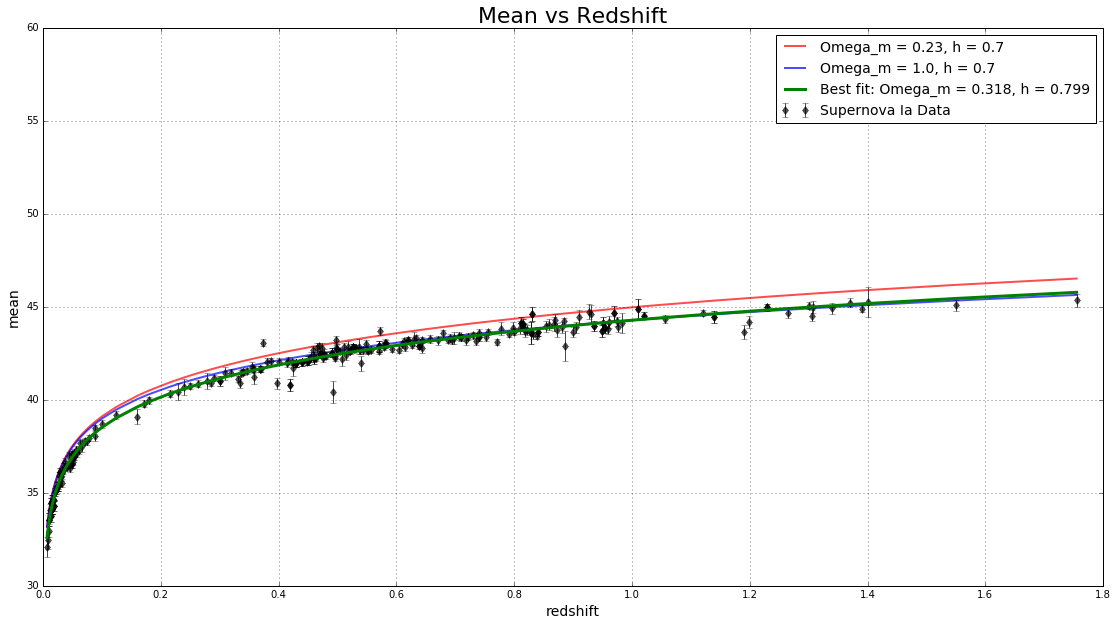

C:
Best fit, fits pretty well with Theoretical plot for Omega_m= 1.0
A chi squared around one is assumed to be a good fit.
 
Chisquared for theoretical plot Omega_m of 0.23: 11.1700691132
Chisquared for theoretical plot Omega_m of 1.0: 0.673360096309
 
Best fit Chisquared: 1.49795317336


In [6]:
def chi2(params, args=(z,mu,err)): 
    h, OmegaM = params
    MU0 = MU(z, params) 
    for i in range(steps):
        chi2 = 0.0
        chi2 += np.power((mu[i]-MU0[i]),2.0)/np.power(err[i],2.0) 
    return chi2


fitfunc = lambda params, z: MU(z, params) 
errfunc = lambda params, z, y: fitfunc(params, z) - y 
p0 = params1 
p1, success = optimize.leastsq(errfunc, p0[:], args=(z, mu))


plt.figure(figsize=(19,10))
plt.plot(z, MU(z, params0), 'r', linewidth=2, alpha=0.7, label='Omega_m = 0.23, h = 0.7')
plt.plot(z, MU(z, params1), 'b', linewidth=2, alpha=0.7, label='Omega_m = 1.0, h = 0.7')
plt.errorbar(z, mu, yerr=err, fmt='cd',color='black', ecolor='black', alpha=0.7, label='Supernova Ia Data')
plt.plot(z, MU(z, p1), 'b', linewidth=3,color='green', label='Best fit: Omega_m = 0.318, h = 0.799')
plt.legend(fontsize=14, loc=1)
plt.ylim(30,60)
plt.xlabel('redshift',fontsize=14)
plt.ylabel('mean',fontsize=14)
plt.title('Mean vs Redshift',fontsize=22)
plt.grid()
plt.show()

print "C:"
print"Best fit, fits pretty well with Theoretical plot for Omega_m= 1.0"
print "A chi squared around one is assumed to be a good fit."

print  ' '
print "Chisquared for theoretical plot Omega_m of 0.23: "+str(chi2(params0, args=(z,mu,err)))
print "Chisquared for theoretical plot Omega_m of 1.0: "+str(chi2(params1, args=(z,mu,err))) 
print' '
print "Best fit Chisquared: "+str(chi2(p1, args=(z,mu,err))) 


In [4]:
print p1


[ 0.79921815  0.31796905]


In [5]:
def lnprob(params, z,mu,err):
    return np.power(chi2(params, args=(z,mu,err)),2)/2.0

ndim = 2

means = np.random.rand(ndim)

cov = 0.5 - np.random.rand(ndim ** 2).reshape((ndim, ndim))
cov = np.triu(cov)
cov += cov.T - np.diag(cov.diagonal())
cov = np.dot(cov,cov)

icov = np.linalg.inv(cov)

nwalkers = 250
p0 = np.random.rand(ndim * nwalkers).reshape((nwalkers, ndim))

sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, args=[z,mu,err])


sampler.run_mcmc(p0, 100)
sampler.reset()


""""

sampler.run_mcmc(pos, 1000)


for i in range(ndim):
    plt.figure()
    plt.hist(sampler.flatchain[:,i], 100, color="k", histtype="step")
    plt.title("Dimension {0:d}".format(i))

plt.show()

print("Mean acceptance fraction: {0:.3f}"
                .format(np.mean(sampler.acceptance_fraction)))
"""


/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:49: RuntimeWarning: invalid value encountered in log10
/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:27: RuntimeWarning: invalid value encountered in sqrt
//anaconda/lib/python2.7/site-packages/scipy/integrate/quadpack.py:352: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  warnings.warn(msg, IntegrationWarning)


NaN value of lnprob for parameters: 
[-0.3001686   0.07272371]
[-0.0018064   0.64106576]
[ 0.44187914 -0.07293101]
[-0.15223079  0.50172806]
[-0.11678549  0.64050975]
[ 0.98121042 -0.11407846]
[ 0.83806413 -0.36328264]
[-0.06612256  0.53048857]
[-0.24660829  0.38071584]
[-0.15032843  1.15400835]
[-0.54399974  1.47679996]
[-0.00350967  0.58476894]
[-0.00230647  0.1097378 ]
[-0.77647012  0.34088379]
[ 1.20778684 -0.40678797]
[-0.08323748 -0.04623088]
[-0.14309363 -0.00314843]


ValueError: lnprob returned NaN.